<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/09_SkimLit_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
NLP model to make reading medical abstracts easier

## Paper referenced:
* [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)
* [https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)

In [65]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4272304a-5d27-2a35-57e0-c2aa4b98e5c7)


# Getting & Pre-Processing Data
Source: [https://github.com/Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [66]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [67]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [68]:
!head pubmed-rct/PubMed_20k_RCT/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( 0-100 mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .
METHODS	Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein

In [69]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [70]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [71]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [72]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [73]:
for i in enumerate(train_lines[:10]):
  print(i)

(0, '###24293578\n')
(1, 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n')
(2, 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n')
(3, 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n')
(4, 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n')
(5, 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n')
(6, 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis fa

In [74]:
def preprocess_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  
 
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

     
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target, text = abstract_line.split("\t")
        line_data["target"] = target
        line_data["text"] = text.lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [76]:
%%time
train_samples = preprocess_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 421 ms, sys: 64.5 ms, total: 486 ms
Wall time: 479 ms


# Visualising Dataset

In [78]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [79]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

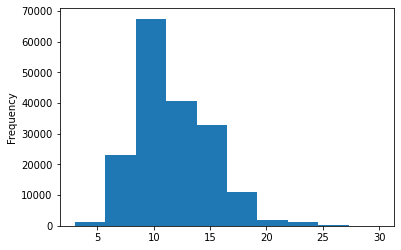

In [80]:
train_df.total_lines.plot.hist();

# Vectorizing text

In [81]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)